# Figure Notebook

In [1]:
"""
Import needed libraries
"""

import numpy as np
import pandas as pd
from copy import copy
import sys
import my_shell_tools

# analysis
from scipy.stats import ttest_ind_from_stats
import itertools

# geomip_data
import os.path
# import cf
from netCDF4 import Dataset

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2

In [40]:
"""
Import all from projects python scripts
"""

from gfdl_data import *
from get_glens_data import *
from analysis import *
from plotting import *

In [38]:
"""
How much of this needed?
"""

# Directory and filenames for annual timeseries of 2D data
glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_template = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'

vars_glens = ['TREFHT','TREFHTMX','P-E','PRECTMX','PRECT']
exps_glens = ['control','feedback']
years = ['2010-2029','2075-2094']

# year ranges which appears in filename
control_file_years = '201001-209912'
control_short_file_years = '201001-203012'
feedback_file_years = '202001-209912'

seas = 'ann'
stats = ['mean','std']

"""
Specify years of experiments and associated indices for annual files
"""

years_control = np.array([IDX + 2010 for IDX in range(90)])
years_feedback = np.array([IDX + 2020 for IDX in range(80)])

#Generate the indices for the range of years in each case.
# [0] added as a 2 element tuple with an array and an empty slot returned rather than an array
t_index_control = np.where((years_control > 2074) & (years_control < 2095))[0]
t_index_baseline = np.where((years_control > 2009) & (years_control < 2030))[0]
t_index_feedback = np.where((years_feedback > 2074) & (years_feedback < 2095))[0]

# Years when GLENS anom = half eventual cooling found using offline calculation with this function call: closest_years_to_frac_GLENS(0.5)
t_index_feedback_half = np.where((years_feedback > 2043) & (years_feedback < 2064))[0]
t_index_control_half = np.where((years_control > 2043) & (years_control < 2064))[0]

"""
How much of this needed?
"""

'\nHow much of this needed?\n'

In [41]:
"""
Generate means and stds for all variables and cases
"""

# get lons, lats and weights
lons, lats, weights = get_lons_lats_weights()

# returnes (Means, Stds) for all cases and vars
all_data = get_all_cases_vars() # {(var,case)}
"""
CASES:
'Baseline'     - RCP8.5 @ 2010-2029
'RCP8.5'       - RCP8.5 @ 2075-2094
'Full-GLENS'   - GLENS  @ 2075-2094
'Half-GLENS'   - Scaled Half-GLENS  @ 2075-2094
'Baseline-2'   - RCP8.5 @ 2010-2029 W/ alternate runs
'Full-GLENS-2'   - GLENS @ 2075-2094 W/ alternate runs
'Half-GLENS-2'   - Scaled Half-GLENS @ 2075-2094 W/ alternate runs on GLENS (not on RCP8.5)
### NOT DONE ### 'Half-GLENS-time' - Shifted Half-GLENS @ 2075-2094 AND ?????
"""

# get weights and masks
all_masks = get_glens_masks_weights() # all_masks[masks]
"""
MASKS:
'land_mask' - binary land mask where land fraction > 50%
'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
WEIGHTS:
'pop' - gridcell weighting by population fraction
'ag' - gridcell weighting by agricultural land fraction
'area' - simple gridcell weighting by area
'land_area' - land area weighting using raw land area fraction (not mask)
'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
"""


"\nMASKS:\n'land_mask' - binary land mask where land fraction > 50%\n'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%\nWEIGHTS:\n'pop' - gridcell weighting by population fraction\n'ag' - gridcell weighting by agricultural land fraction\n'area' - simple gridcell weighting by area\n'land_area' - land area weighting using raw land area fraction (not mask)\n'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)\n"

In [5]:
"""
Set standard plot options
"""

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'figure.figsize': cm2inch(8.5,8.5)})

# color guide here: https://www.w3schools.com/colors/colors_picker.asp
# color blender here: https://meyerweb.com/eric/tools/color-blend
red = '#ff0000'
l_red = '#ffc0c0' # old: '#ffd9d9'
blue = '#0066ff'
l_blue = '#c0c0ff' # old:'#b2d0ff'
purple = '#803380'
l_purple = '#C099C0' 

std_alpha = 0.2

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300 # set inline images to hi-res
%matplotlib inline

# INSERT FIGURE SECTIONS HERE

In [43]:
# %load figure_sections/frac_summary_figure_data.py
"""
Code to generate input data for fraction summary figure
"""

def frac_figure_data(frac, var_list, all_data, all_masks, weight_name = 'land_noice_area', nyears=80, ttest_level=0.1):
    """
    function to generate a table of data to input to summary figure (fig "4" from NCC paper)
    """
    # Generate masks
    global_weight = all_masks['area'].flatten()
    weight = all_masks[weight_name].flatten()

    # create Dict to fill with data and then return
    inner_dict = {}
    
    #loop over all vars
    for var in var_list:

        """
        Generate Fraction-data
        """

        CO2_mean = all_data[var,'RCP8.5'][0].flatten()
        SRM_mean = all_data[var,'Full-GLENS'][0].flatten()
        CTRL_mean = all_data[var,'Baseline'][0].flatten()

        CO2_std = all_data[var,'RCP8.5'][1].flatten()
        SRM_std = all_data[var,'Full-GLENS'][1].flatten()
        CTRL_std = all_data[var,'Baseline'][1].flatten()

        """
        Generate Fraction-data
        """

        frac_mean = CO2_mean + frac*(SRM_mean - CO2_mean)
        frac_std = CO2_std + frac*(SRM_std - CO2_std)
        frac_anom = frac_mean - CTRL_mean

        """
        Generate fraction moderated / exacerbated
        """

        better, worse, dont_know = better_worse_off(frac_mean, frac_std, CO2_mean, CO2_std, CTRL_mean, CTRL_std, nyears, ttest_level)

        """
        Root-mean square
        """

        frac_anom_squared = frac_anom**2
        frac_std_anom_squared = (frac_anom / CTRL_std)**2
        RMS = ( np.sum(weight * frac_anom_squared) )**0.5
        RMS_std = ( np.sum(weight * frac_std_anom_squared) )**0.5

        """
        Fill dict with data
        """

        inner_dict[var+'_global'] = np.sum(frac_anom * global_weight)
        inner_dict[var+'_RMS'] = RMS
        inner_dict[var+'_RMS_std'] = RMS_std
        inner_dict[var+'_mod'] = np.sum(better.flatten() * weight)
        inner_dict[var+'_exa'] = np.sum(worse.flatten() * weight)
    #endfor var 
       
    # Return dict of output    
    return inner_dict
# end def frac_figure_data()

def dict_flipper(dict_to_flip):
    """
    Flips a 2-layer dictionary inside out
    """

    flip_dict = {}

    outer_keys = list(dict_to_flip.keys())
    inner_keys = list(dict_to_flip[outer_keys[0]].keys())

    for inner_key in inner_keys:
        
        temp_dict = {}

        for outer_key, inner_dict in dict_to_flip.items():
            temp_dict[outer_key] = inner_dict[inner_key]

        flip_dict[inner_key] = temp_dict
    
    # return flipped dict
    return flip_dict
#end def

"""
generate table of data for figure
"""

out_dir = "/n/home03/pjirvine/projects/GLENS_fraction_better_off/tables/"

# Create an array of output from 0 to 1.5x GLENS
frac_array = np.arange(0.,1.51,0.01)

# fill a dictionary with the output
dict_variable = {round(FRAC,2):frac_figure_data(FRAC, vars_glens, all_data, all_masks) for FRAC in frac_array}

# Flip the dictionary around to have frac as the inner element
flip_dict = dict_flipper(dict_variable)

"""
Output Dict to CSV
"""

pd.DataFrame.from_dict(flip_dict).to_csv(out_dir + 'results_by_frac_GLENS.csv')

# END


/n/home03/pjirvine/.conda/envs/climate_odyssey/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


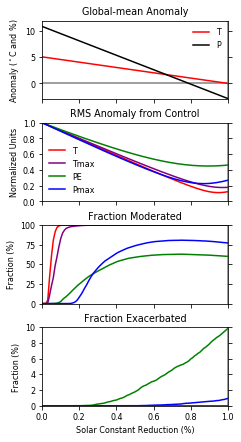

In [54]:
"""
Figure to plot RMS, etc. as a function of solar constant reduction
"""

out_dir = '/n/home03/pjirvine/projects/GLENS_fraction_better_off/figures/'

# load up GeoMIP regional data
table_dir = '/n/home03/pjirvine/projects/GLENS_fraction_better_off/tables/'
frac_pd = pd.DataFrame.from_csv(table_dir + 'results_by_frac_GLENS.csv')
frac_dict = frac_pd.to_dict()

vars_all = ['TREFHT','TREFHTMX','P-E','PRECTMX','PRECT']
vars_no_p = ['TREFHT','TREFHTMX','P-E','PRECTMX']

metrics = ['global','RMS','RMS_std','mod','exa']

# x-axis
x = frac_dict['P-E_RMS'].keys()

"""
Begin Plots
"""

fig = plt.figure(figsize=cm2inch(8.5,18))
plt.rcParams.update({'font.size': 8})

var_cols = {'TREFHT':'red',
            'TREFHTMX':'purple',
            'PRECTMX':'blue',
            'P-E':'green',
            'PRECT':'black'}

var_labels = {'TREFHT':'T',
              'TREFHTMX':'Tmax',
              'PRECTMX':'Pmax',
              'P-E':'PE',
              'PRECT':'P'}
            

"""
Global-mean plot
"""

ax1 = fig.add_subplot(411)

# generate control global-mean precip
control_precip = all_data['PRECT','Baseline'][0].flatten()
global_weight = all_masks['land_noice_area'].flatten()
control_global_precip = np.sum(control_precip * global_weight)

global_temp = frac_pd['TREFHT_global']
global_precip_pc = 100.0 * (frac_pd['PRECT_global'] / control_global_precip)

plt.plot(global_temp, color = var_cols['TREFHT'], label= var_labels['TREFHT'])
plt.plot(global_precip_pc, color = 'k', label = 'P')

plt.xlim(0,1)
plt.ylim(-3,12)

plt.axhline(0.,color='gray',zorder=0)
plt.axvline(1.,color='gray',zorder=0)

plt.title('Global-mean Anomaly')
plt.ylabel('Anomaly ($^\circ$C and %)')

plt.legend(frameon=False)

"""
RMS plot
"""

ax2 = fig.add_subplot(412)

for var in vars_no_p:
    
    RMS = frac_pd[var+'_RMS'] / frac_pd[var+'_RMS'][0]
    plt.plot(RMS, color = var_cols[var], label= var_labels[var])

plt.ylim(0,1)
plt.xlim(0,1)

plt.axvline(1.,color='gray',zorder=0)

plt.title('RMS Anomaly from Control')
plt.ylabel('Normalized Units')


plt.legend(frameon=False)

"""
Fraction moderated plot
"""

ax3 = fig.add_subplot(413)

for var in vars_no_p:
    
    mod = 100. * frac_pd[var+'_mod']
    plt.plot(mod, color = var_cols[var], label= var_labels[var])

plt.axvline(1.,color='gray',zorder=0)
    
plt.ylim(0,100)
plt.xlim(0,1)

plt.title('Fraction Moderated')
plt.ylabel('Fraction (%)')

# plt.legend(frameon=False)

"""
Fraction exacerbated plot
"""

ax4 = fig.add_subplot(414)

for var in vars_no_p:
    
    exa = 100. * frac_pd[var+'_exa']
    plt.plot(exa, color = var_cols[var], label= var_labels[var])

# plt.text(0.88,7,'half-SG',rotation=90)
plt.axvline(1.,color='gray',zorder=0)
    
plt.ylim(0,10)
plt.xlim(0,1)

plt.title('Fraction Exacerbated')
plt.ylabel('Fraction (%)')
plt.xlabel('Solar Constant Reduction (%)')

# plt.legend(frameon=False)

"""
Tidy up figure
"""

ax1.get_xaxis().set_ticklabels([])
ax2.get_xaxis().set_ticklabels([])
ax3.get_xaxis().set_ticklabels([])

ax1.tick_params(axis='y', right=True)
ax2.tick_params(axis='y', right=True)
ax3.tick_params(axis='y', right=True)
ax4.tick_params(axis='y', right=True)

ax2.get_yaxis().set_ticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax4.get_yaxis().set_ticks([0, 2, 4, 6, 8, 10])

fig.subplots_adjust(left=0.18, right=0.95, hspace=0.3)

plt.savefig(out_dir+'fig_4.png', format='png', dpi=480)
plt.savefig(out_dir+'fig_4.eps', format='eps', dpi=480)

plt.show()

# 

# Loading Example NetCDF to see contents and map results

In [ ]:
"""
Example netcdf file of annual series + gather lons and lats
"""

"""
variables(dimensions): float64 time(time), float64 time_bnds(time,bnds), 
    float64 lat(lat), float64 lon(lon), float64 gw(lat), float64 ch4vmr(time), 
    float64 co2vmr(time), int32 ndcur(time), int32 date(time), int32 nscur(time), 
    float64 sol_tsi(time), int32 nsteph(time), float64 f11vmr(time), float64 n2ovmr(time), 
    int32 datesec(time), float64 f12vmr(time), float32 TREFHT(time,lat,lon)
"""

var='TREFHT'
exp='control'
run='001'
file_years='201001-209912'

glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_filename = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'.format(exp=exp,run=run,var=var,years=file_years)

glens_fileloc = glens_dir + glens_filename
test_nc = Dataset(glens_fileloc)

lons = np.array(test_nc.variables['lon'][:])
lats = np.array(test_nc.variables['lat'][:])

# grid-weights by latitude
gw = test_nc.variables['gw'][:]
gw_2D = np.tile(gw, (lons.size,1))
gw_2D = gw_2D / np.sum(gw_2D)

In [ ]:
# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

fix_dir = '/n/home03/pjirvine/keithfs1_pji/geomip_archive/final_data/CCSM4/fix/'
filename = 'sftlf_CCSM4.nc'
test_nc = Dataset(fix_dir + filename)

nc_data = test_nc.variables['sftlf'][:].transpose()

In [ ]:
nc_data.shape

In [ ]:
    """
    MASKS:
    'land_mask' - binary land mask where land fraction > 50%
    'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
    WEIGHTS:
    'pop' - gridcell weighting by population fraction
    'ag' - gridcell weighting by agricultural land fraction
    'area' - simple gridcell weighting by area
    'land_area' - land area weighting using raw land area fraction (not mask)
    'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
    """

In [ ]:
"""
Example cartopy plot

http://earthpy.org/tag/cartopy.html
https://scitools.org.uk/cartopy/docs/v0.16/matplotlib/advanced_plotting.html
"""

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from matplotlib import cm
import cartopy.crs as ccrs

from cartopy.util import add_cyclic_point

# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

# nc_data = test_nc.variables['TREFHT'][:].transpose()
# data = np.mean(nc_data,2)

# data = all_masks['land_noice_mask'].transpose()

data = all_data[('P-E','Baseline')][0]

ax = plt.axes(projection=ccrs.PlateCarree())

# plt.figure(figsize=(13,6.2))  
# ax = plt.subplot(111, projection=ccrs.PlateCarree())

lons2d, lats2d = np.meshgrid(lons, lats)

plt.contourf(lons2d, lats2d, data.transpose(), 60,
             transform=ccrs.PlateCarree())

ax.coastlines()

# fig.colorbar(cm.ScalarMappable(),ax=ax)

plt.show()

data

In [ ]:
plt.imshow(all_data[('P-E','RCP8.5')][0])